# Test classo
code edited from CentralPark example in GitHub repos [here](https://github.com/Leo-Simpson/c-lasso/blob/master/examples/example_CentralParkSoil.py)

## Import

In [1]:
from os.path import join
from classo import classo_problem
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
data_dir = join("data", "CentralParkSoil")
data = np.load(join(data_dir, "cps.npz"))

# X are relative abundances
x = data["x"]  # (580, 3379)

# y is target
y = data["y"]  # (580,)

label = data["label"]  # (3704,) = 3379 OTUs + 325 nodes in tree
label_short = np.array([la.split("::")[-1] for la in label])

In [3]:
# A is tree # todo: find out how to create this particular tree
# ! creation of A: my planned approach
# ! df_taxonomy = perform_taxonomic_classification()
# ! A = create_tree(df_taxonomy)
# ! create_tree should transform df with assignments to a 0,1 matrix:
# as in here: function "phylo_to_A":
# https://github.com/jacobbien/trac/blob/b6b9f4c08391d618152c4e02caf9eb4d6798aed8/R/getting_A.R#L64
A = np.load(join(data_dir, "A.npy"))  # numpy array: (3379, 3704)
# 3704 = 3379 OTUs + 325 nodes in tree

## Preprocess: taxonomy aggregation

In [4]:
pseudo_count = 1
X = np.log(pseudo_count + x)
nleaves = np.sum(A, axis=0)
logGeom = X.dot(A) / nleaves

n, d = logGeom.shape

In [5]:
# define train set: tr
tr = np.random.permutation(n)[: int(0.8 * n)]

## Cross validation and Path Computation

In [6]:
problem = classo_problem(logGeom[tr], y[tr], label=label_short)

problem.formulation.w = 1 / nleaves
problem.formulation.intercept = True
problem.formulation.concomitant = False  # not relevant for here

# ! one form of model selection needs to be chosen
# stability selection: for pre-selected range of lambda find beta paths
problem.model_selection.StabSel = False
# calculate coefficients for a grid of lambdas
problem.model_selection.PATH = False
# todo: check if it is fair that trac is trained with CV internally whereas others are not
# lambda values checked with CV are `Nlam` points between 1 and `lamin`, with
# logarithm scale or not depending on `logscale`.
problem.model_selection.CV = True
problem.model_selection.CVparameters.seed = (
    6  # one could change logscale, Nsubset, oneSE
)
# 'one-standard-error' = select simplest model (largest lambda value) in CV
# whose CV score is within 1 stddev of best score
# ! create hyperparameter for this
problem.model_selection.CVparameters.oneSE = True
# ! create hyperparameter for this
problem.model_selection.CVparameters.Nlam = 80
# ! create hyperparameter for this
problem.model_selection.CVparameters.lamin = 0.001

# ! for ritme: no feature_transformation to be used for trac
print(problem)

 
 
FORMULATION: R1
 
MODEL SELECTION COMPUTED:  
     Cross Validation
 
CROSS VALIDATION PARAMETERS: 
     numerical_method : not specified
     one-SE method : True
     Nsubset = 5
     lamin = 0.001
     Nlam = 80
     with log-scale



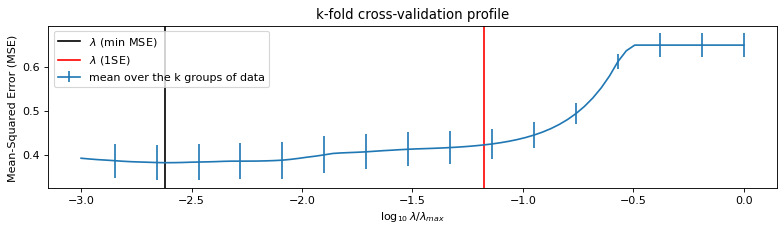

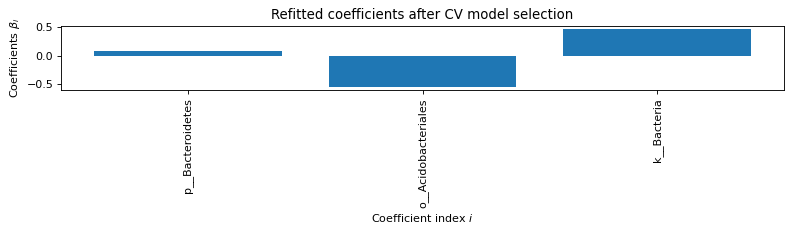


 CROSS VALIDATION : 
    Intercept : 5.9122282516799585
   Selected variables :  p__Bacteroidetes    o__Acidobacteriales    k__Bacteria    
   Running time :  12.524s



In [7]:
problem.solve()
print(problem.solution)

In [8]:
# ! class solution_CV: defined in @solver.py L930
selection = problem.solution.CV.selected_param[1:]  # exclude the intercept
print(label[selection])

['Life::k__Bacteria::p__Bacteroidetes'
 'Life::k__Bacteria::p__Acidobacteria::c__Acidobacteriia::o__Acidobacteriales'
 'Life::k__Bacteria']


In [9]:
dir(problem.solution.CV)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'beta',
 'formulation',
 'graphic',
 'index_1SE',
 'index_min',
 'label',
 'lambda_1SE',
 'lambda_min',
 'logscale',
 'refit',
 'save1',
 'save2',
 'selected_param',
 'standard_error',
 'time',
 'xGraph',
 'yGraph']

In [10]:
# selected lambda with 1-standard-error method
problem.solution.CV.lambda_1SE

0.06649435996665047

In [11]:
# selected lambda without 1-standard-error method
problem.solution.CV.lambda_min

0.0023974349678010775

## Prediction plot

In [12]:
# define test set
te = np.array([i for i in range(len(y)) if i not in tr])

# alpha [0] is learned intercept, alpha [1:] are learned coefficients for all features
# in logGeom (n_samples, n_features)
# ! if oneSE=True -> uses lambda_1SE else lambda_min (see CV in
# ! classo>cross_validation.py)
# refit -> solves unconstrained least squares problem with selected lambda and
# variables
alpha = problem.solution.CV.refit
len(alpha)

3705

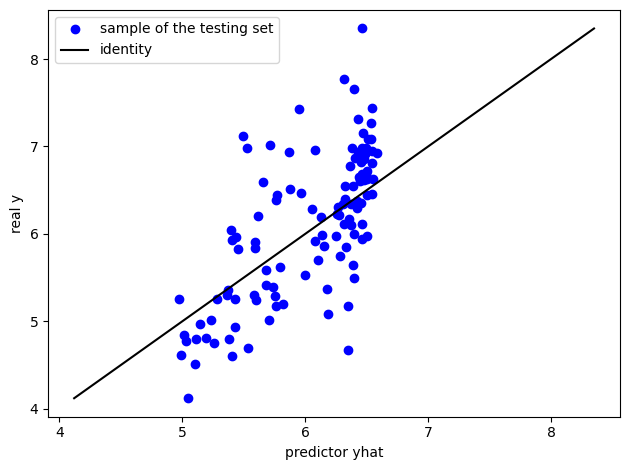

In [13]:
# model prediction
yhat = logGeom[te].dot(alpha[1:]) + alpha[0]

M1, M2 = max(y[te]), min(y[te])
plt.plot(yhat, y[te], "bo", label="sample of the testing set")
plt.plot([M1, M2], [M1, M2], "k-", label="identity")
plt.xlabel("predictor yhat"), plt.ylabel("real y"), plt.legend()
plt.tight_layout()
plt.show()

## Stability selection

 
 
FORMULATION: R1
 
MODEL SELECTION COMPUTED:  
     Stability selection
 
STABILITY SELECTION PARAMETERS: 
     numerical_method : Path-Alg
     method : first
     B = 50
     q = 10
     percent_nS = 0.5
     threshold = 0.7
     lamin = 0.01
     Nlam = 50
 

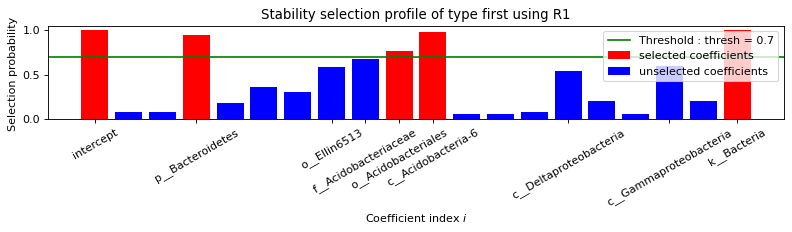

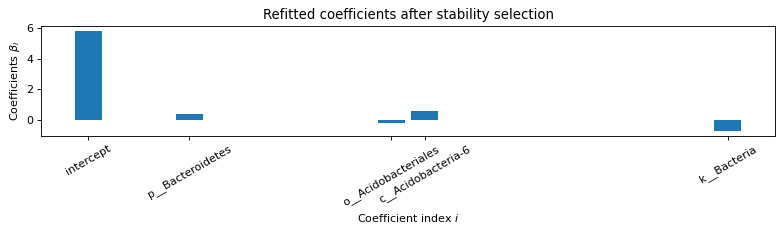


 STABILITY SELECTION : 
   Selected variables :  intercept    p__Bacteroidetes    o__Acidobacteriales    c__Acidobacteria-6    k__Bacteria    
   Running time :  44.955s

['Life::k__Bacteria::p__Bacteroidetes'
 'Life::k__Bacteria::p__Acidobacteria::c__Acidobacteriia::o__Acidobacteriales'
 'Life::k__Bacteria::p__Acidobacteria::c__Acidobacteria-6'
 'Life::k__Bacteria']


In [14]:
problem = classo_problem(logGeom[tr], y[tr], label=label_short)

problem.formulation.w = 1 / nleaves
problem.formulation.intercept = True
problem.formulation.concomitant = False


problem.model_selection.PATH = False
problem.model_selection.CV = False
# can change q, B, nS, method, threshold etc in problem.model_selection.StabSelparameters

problem.solve()

print(problem, problem.solution)

selection = problem.solution.StabSel.selected_param[1:]  # exclude the intercept
print(label[selection])

## Prediction plot

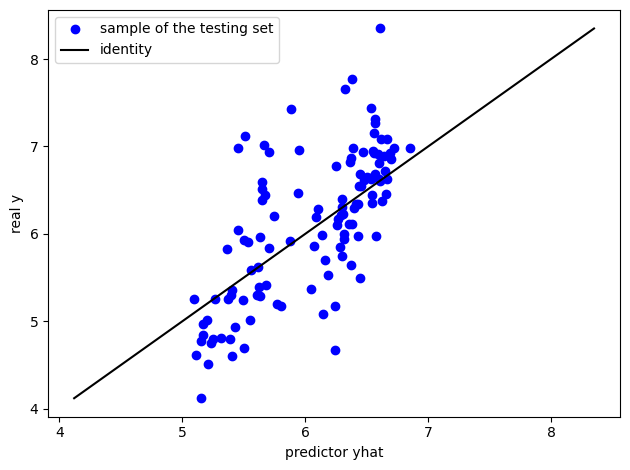

In [15]:
te = np.array([i for i in range(len(y)) if i not in tr])
alpha = problem.solution.StabSel.refit
yhat = logGeom[te].dot(alpha[1:]) + alpha[0]

M1, M2 = max(y[te]), min(y[te])
plt.plot(yhat, y[te], "bo", label="sample of the testing set")
plt.plot([M1, M2], [M1, M2], "k-", label="identity")
plt.xlabel("predictor yhat"), plt.ylabel("real y"), plt.legend()
plt.tight_layout()